VAE　オートエンコーダー

参考文献　我妻幸長　「はじめてのディープラーニング２」

In [1]:
#　colaboraory用: Google drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# colaboratory用: フォルダを移る
%cd "drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


フォルダは自分の指定のものに変更してね。

In [3]:
%cd "ctorch210701/MiniCTorch_Prototype"

/content/drive/My Drive/Colab Notebooks/ctorch210701/MiniCTorch_Prototype


In [4]:
! pip install lark-parser

     |████████████████████████████████| 229 kB 36.9 MB/s 
  Created wheel for lark-parser: filename=lark_parser-0.11.3-py2.py3-none-any.whl size=99739 sha256=54021ff6518b479a88b6f276208a77d653f1016b1516d11bb486ec72586368fd
  Stored in directory: /root/.cache/pip/wheels/2d/f0/65/7aea47a49de7acac0108aac16a7ee00eb996f872d978feb87e
Successfully built lark-parser


In [5]:
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import minictorch
import minictorch.generator as GN
import minictorch.converter as CV

サンプルデータ

In [6]:
import torch.utils as utils
from torchvision import datasets, transforms
from sklearn import datasets

img_size = 8
n_in = img_size * img_size
n_mid = 16
n_out = n_in
n_z = 2

digits_data = datasets.load_digits()
dd = np.asarray( digits_data.data, dtype=np.float32 )
dd /= 15
x_train = torch.from_numpy( dd ).clone()

サンプルデータの図化

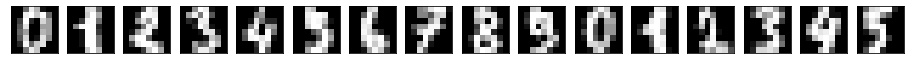

In [7]:
import matplotlib.pyplot as plt
n_img = 16

plt.figuｒe( figsize=(16,3))
for i in range(n_img):
  ax = plt.subplot(3,n_img,i+1)
  plt.imshow(dd[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

ニューラルネットワークの定義

In [8]:
def mean_squared_error( x0, x1 ):
    diff = x0 - x1
    y = (diff*diff).sum() / len(diff)
    return y;

class Net(torch.nn.Module):
  def __init__( self, n_in, n_mid, n_out, n_z, e ):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_in, n_mid)
    self.fc2_mean = nn.Linear(n_mid, n_z)
    self.fc2_var  = nn.Linear(n_mid, n_z)
    self.fc3 = nn.Linear(n_z  ,n_mid)
    self.fc4 = nn.Linear(n_mid,n_out)
    self.eps = e
  
  def forward(self,x):
    # encoder
    x = F.relu( self.fc1(x) )
    self.mean    = self.fc2_mean(x)
    self.log_var = self.fc2_var(x)

    # reparametrization
    #print(self.mean.shape)
    #eps = torch.randn( mean.shape, device="cpu" )
    z = self.mean + self.eps * torch.exp( 0.5 * self.log_var )
    #z = self.mean + 0.5 * torch.exp( 0.5 * self.log_var )

    # decoder
    y = F.relu( self.fc3(z) )
    y = torch.sigmoid( self.fc4(y) )
    return y

In [9]:
def generate_json( json_path, input, e ):

    model = Net( n_in, n_mid, n_out, n_z, e )

    model.eval()
    with torch.no_grad():
        print("[SAVE]", json_path )
        GN.generate_minictorch_file( model, input, json_path )

    return model

torch.manual_seed( 1 )

project = 'vae1'
json_path = 'network/' + project +'.json'

x = x_train.clone().detach()
torch.reshape( x, (-1,n_in) )

batch_size=32
x = x[0:batch_size,:]
#print(type(x))
#print(x.shape)
x.requires_grad = True

e = torch.randn( batch_size, 2 )
print("eps",e)

model = generate_json( json_path, x, e )

with torch.set_grad_enabled(True):
  model.eval()
  output = model( x )
  print(output)
  output.sum().backward()
  print("fc1_w",model.fc1.weight.grad)
  print("fc1_b",model.fc1.bias.grad)
  print("fc2_mean_w",model.fc2_mean.weight.grad)
  print("fc2_mean_b",model.fc2_mean.bias.grad)
  print("fc2_var_w",model.fc2_var.weight.grad)
  print("fc2_var_b",model.fc2_var.bias.grad)
  #print("output",output.grad)
  print("input",x.grad)

eps tensor([[-1.5256, -0.7502],
        [-0.6540, -1.6095],
        [-0.1002, -0.6092],
        [-0.9798, -1.6091],
        [-0.7121,  0.3037],
        [-0.7773, -0.2515],
        [-0.2223,  1.6871],
        [ 0.2284,  0.4676],
        [-0.6970, -1.1608],
        [ 0.6995,  0.1991],
        [ 0.8657,  0.2444],
        [-0.6629,  0.8073],
        [ 1.1017, -0.1759],
        [-2.2456, -1.4465],
        [ 0.0612, -0.6177],
        [-0.7981, -0.1316],
        [ 1.8793, -0.0721],
        [ 0.1578, -0.7735],
        [ 0.1991,  0.0457],
        [ 0.1530, -0.4757],
        [-0.1110,  0.2927],
        [-0.1578, -0.0288],
        [ 2.3571, -1.0373],
        [ 1.5748, -0.6298],
        [-0.9274,  0.5451],
        [ 0.0663, -0.4370],
        [ 0.7626,  0.4415],
        [ 1.1651,  2.0154],
        [ 0.1374,  0.9386],
        [-0.1860, -0.6446],
        [ 1.5392, -0.8696],
        [-3.3312, -0.7479]])
[SAVE] network/vae1.json
skip: Net/Linear[fc1]/weight/51
skip: Net/Linear[fc1]/weight/51
skip: Net/

In [10]:
def convert_json( project, model, input_x, json_path, rand_flag=0 ):

    folder = "src"
    cpp_fname   = project + ".cpp"
    param_fname = project + "_param.cpp"
    cpp_path    = folder + "/" + cpp_fname
    param_path  = folder + "/" + param_fname
    make_path   = folder + "/" + "Makefile"

    # load json file
    print( "[JSON]", json_path )
    fp = open( json_path )
    obj = json.load( fp )

    # save parameter file
    code1 = CV.c_param_generator( obj, model, input_x )
    if len( code1 ) > 0:
       print( "[PARAM]", param_path )
       ofparam = open( param_path, "w" )
       ofparam.write( code1 )

    # save cpp file
    print( "[CPP]  ", cpp_path )
    code2 = CV.c_code_generator( obj, model, rand_flag )

    #ofp=open(args.path+"/"+args.output,"w")
    ofp = open( cpp_path, "w" )
    ofp.write( code2 )

    # save make file
    print( "[MAKE] ", make_path )
    make_code = CV.makefile_generator( cpp_fname )

    #makefp=open(args.path+"/"+"Makefile","w")
    makefp = open( make_path, "w" )
    makefp.write( make_code )

convert_json( project, model, x, json_path )

[JSON] network/vae1.json
{'name': 'Net/Linear[fc1]/weight/75', 'op': 'prim::GetAttr', 'in': [], 'shape': [], 'out': [3], 'sorted_id': 1}
{'name': 'Net/Linear[fc1]/bias/74', 'op': 'prim::GetAttr', 'in': [], 'shape': [], 'out': [3], 'sorted_id': 2}
{'name': 'Net/Linear[fc2_mean]/weight/78', 'op': 'prim::GetAttr', 'in': [], 'shape': [], 'out': [7], 'sorted_id': 5}
{'name': 'Net/Linear[fc2_mean]/bias/77', 'op': 'prim::GetAttr', 'in': [], 'shape': [], 'out': [7], 'sorted_id': 6}
{'name': 'Net/Linear[fc2_var]/weight/81', 'op': 'prim::GetAttr', 'in': [], 'shape': [], 'out': [11], 'sorted_id': 9}
{'name': 'Net/Linear[fc2_var]/bias/80', 'op': 'prim::GetAttr', 'in': [], 'shape': [], 'out': [11], 'sorted_id': 10}
{'name': 'Net/Linear[fc3]/weight/84', 'op': 'prim::GetAttr', 'in': [], 'shape': [], 'out': [20], 'sorted_id': 18}
{'name': 'Net/Linear[fc3]/bias/83', 'op': 'prim::GetAttr', 'in': [], 'shape': [], 'out': [20], 'sorted_id': 19}
{'name': 'Net/Linear[fc4]/weight/87', 'op': 'prim::GetAttr', '

In [11]:
!g++ -std=c++14 ./src/vae1.cpp ./src/vae1_param.cpp -I ../../ctorch/lib -lcblas -o vae1

In [12]:
!./vae1

### forward computation ...
{{ 0.538287,  0.46543 ,  0.582467, ...,  0.509555,  0.52276 ,  0.458301},
 { 0.582004,  0.431142,  0.623932, ...,  0.529974,  0.539257,  0.45694 },
 { 0.559404,  0.446466,  0.631824, ...,  0.544832,  0.561323,  0.469514},
 ..., 
 { 0.557056,  0.450195,  0.626098, ...,  0.541207,  0.557288,  0.468287},
 { 0.568385,  0.367176,  0.71871 , ...,  0.576077,  0.61352 ,  0.461845},
 { 0.570002,  0.476707,  0.551062, ...,  0.463445,  0.527364,  0.415888}}
### backward computation ...
{{ 0.004268,  0.000391, -0.003091, ..., -0.002567,  0.000024, -0.001582},
 {-0.000393, -0.000384,  0.000247, ...,  0.0001  , -0.000681, -0.000342},
 { 0.000826, -0.035423,  0.008815, ..., -0.004155, -0.021678, -0.013857},
 ..., 
 { 0.009942, -0.022508,  0.00095 , ..., -0.011885, -0.010972, -0.011371},
 { 0.00987 , -0.001199, -0.002351, ..., -0.00999 , -0.008812, -0.014539},
 { 0.005219, -0.023248,  0.018941, ..., -0.005932, -0.024632, -0.00953 }}


  学習　以下、未修正

In [ ]:
num_epochs = 1000

x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y.reshape(-1, 1)).float()

net = Net()
net.train()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

epoch_loss = []
for epoch in range(num_epochs):
  
  outputs = net(x_tensor)
  loss = criterion(outputs, y_tensor)
    
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
    
  epoch_loss.append(loss.data.numpy().tolist())


学習の収束の図化

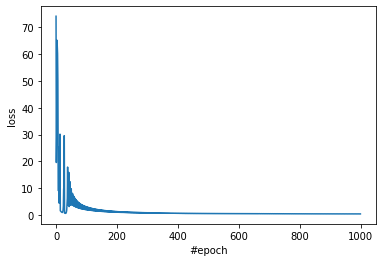

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()

予測

In [ ]:
net.eval()

_x_new = np.linspace(0, 10, 1000)
x1_new = np.sin(_x_new)
x2_new = np.exp(_x_new / 5)
x_new = np.stack([x1_new, x2_new], axis=1)


x_new_tensor = torch.from_numpy(x_new).float()
with torch.no_grad():
    y_pred_tensor = net(x_new_tensor)

y_pred = y_pred_tensor.data.numpy()



fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(_x, y)
ax.plot(_x_new, y_pred, c='orange')
ax.set_xlabel('_x')
ax.set_ylabel('y')
fig.show()